In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install sparqlwrapper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 10.2 MB/s eta 0:00:00


In [ ]:
!pip install pykeen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.4/718.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import os

# Define the dataset path
dataset_path = '/content/drive/MyDrive/ECE1508-Project/Release'

# Load the train, validation, and test datasets
train_data = pd.read_csv(os.path.join(dataset_path, 'train.txt'), sep='\t', header=None, names=['head', 'relation', 'tail'])
valid_data = pd.read_csv(os.path.join(dataset_path, 'valid.txt'), sep='\t', header=None, names=['head', 'relation', 'tail'])
test_data = pd.read_csv(os.path.join(dataset_path, 'test.txt'), sep='\t', header=None, names=['head', 'relation', 'tail'])

print("Train Data Sample:\n", train_data.head())
print("Validation Data Sample:\n", valid_data.head())
print("Test Data Sample:\n", test_data.head())

Train Data Sample:
          head                                           relation       tail
0    /m/027rn               /location/country/form_of_government   /m/06cx9
1   /m/017dcd  /tv/tv_program/regular_cast./tv/regular_tv_app...  /m/06v8s0
2  /m/07s9rl0                 /media_common/netflix_genre/titles  /m/0170z3
3   /m/01sl1q  /award/award_winner/awards_won./award/award_ho...  /m/044mz_
4   /m/0cnk2q  /soccer/football_team/current_roster./sports/s...  /m/02nzb8
Validation Data Sample:
          head                                           relation       tail
0   /m/07pd_j                                   /film/film/genre  /m/02l7c8
1    /m/06wxw                      /location/location/time_zones  /m/02fqwt
2  /m/01t94_1  /people/person/spouse_s./people/marriage/type_...   /m/04ztj
3  /m/02xcb6n  /award/award_category/winners./award/award_hon...  /m/04x4s2
4   /m/07f_7h  /film/film/release_date_s./film/film_regional_...   /m/04gzd
Test Data Sample:
          head           

# Data Loading and Preparation

In [ ]:
import pandas as pd
import os

dataset_path = "/content/drive/MyDrive/ECE1508-Project/Release"  # Replace with your dataset path

train_data = pd.read_csv(os.path.join(dataset_path, 'train.txt'), sep='\t', header=None, names=['head', 'relation', 'tail'])
valid_data = pd.read_csv(os.path.join(dataset_path, 'valid.txt'), sep='\t', header=None, names=['head', 'relation', 'tail'])
test_data = pd.read_csv(os.path.join(dataset_path, 'test.txt'), sep='\t', header=None, names=['head', 'relation', 'tail'])

# Combine for consistent mapping
all_data = pd.concat([train_data, valid_data, test_data])

# Create mappings
entities = pd.unique(all_data[['head', 'tail']].values.ravel('K'))
relations = pd.unique(all_data['relation'])

entity_to_id = {entity: idx for idx, entity in enumerate(entities)}
relation_to_id = {relation: idx for idx, relation in enumerate(relations)}

print(f"Number of entities: {len(entity_to_id)}")
print(f"Number of relations: {len(relation_to_id)}")

# Map data to IDs
def map_ids(df, entity_to_id, relation_to_id):
    df['head'] = df['head'].map(entity_to_id)
    df['tail'] = df['tail'].map(entity_to_id)
    df['relation'] = df['relation'].map(relation_to_id)
    return df

train_data = map_ids(train_data, entity_to_id, relation_to_id)
valid_data = map_ids(valid_data, entity_to_id, relation_to_id)
test_data = map_ids(test_data, entity_to_id, relation_to_id)

print("Data preparation complete.")

Number of entities: 14541
Number of relations: 237
Data preparation complete.


# Create text embeddings with TransE

In [ ]:
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
import numpy as np

data = all_data

triples_array = np.array(data, dtype=str)

# Create a TriplesFactory for the entire dataset
full_triples_factory = TriplesFactory.from_labeled_triples(triples_array)

# Split into training, testing, and validation sets (80-10-10 split)
training_factory, testing_factory, validation_factory = full_triples_factory.split([0.8, 0.1, 0.1])

# Configure the pipeline for TransE
transE_pipeline_result = pipeline(
    model='TransE',
    training=training_factory,
    testing=testing_factory,
    validation=validation_factory,
    model_kwargs={
        'embedding_dim': 10,
    },
    optimizer='Adam',
    optimizer_kwargs={
        'lr': 0.001,
    },
    training_kwargs={
        'num_epochs': 10,
        'batch_size': 256,
    },
)

# Access the trained model
transE_model = transE_pipeline_result.model

# Get entity embeddings
entity_embeddings = transE_model.entity_representations[0](indices=None).detach().numpy()

# Save embeddings to file
np.savez_compressed('/content/drive/MyDrive/ECE1508-Project/embeddings/entity_embeddings.npz', embeddings=entity_embeddings)
print("TransE embeddings generated and saved.")

INFO:pykeen.utils:Using opt_einsum
INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [233707, 31012, 31012]
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/970 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/970 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/970 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/970 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/970 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/970 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/970 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/970 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/970 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/970 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/31.0k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 342.82s seconds


TransE embeddings generated and saved.


In [ ]:
# Instead of directly accessing 'embedding_dim',
# access it through the model's entity_representations attribute and its shape.
input_size_transE = transE_model.entity_representations[0]._embeddings.weight.shape[1]
print(f"Input size of the TransE model: {input_size_transE}")

Input size of the TransE model: 10


Number of parameters in TransE model

In [ ]:
# Get the number of entities and relations
number_of_entities = transE_model.num_entities
number_of_relations = transE_model.num_relations

# Get the embedding dimension
# Accessing the embedding layer's shape through its parameters
embedding_dim = transE_model.entity_representations[0]._embeddings.weight.shape[1]

# Calculate the total number of parameters
total_parameters = (number_of_entities + number_of_relations) * embedding_dim

print(f"Total number of parameters in the TransE model: {total_parameters}")

Total number of parameters in the TransE model: 147780


In [ ]:
# print 1 samples from the embeddings
print(entity_embeddings[:1])
print(entity_embeddings.shape)

[[ 0.41017377  0.28652507 -0.29987425  0.23014799  0.2783445  -0.4979993
  -0.01927705 -0.4266813  -0.02044779 -0.31375584]]
(14541, 10)


In [ ]:
# print the entity name and its embedding using the mapping.
print(entities[0])
print(entity_embeddings[0])

/m/027rn
[ 0.41017377  0.28652507 -0.29987425  0.23014799  0.2783445  -0.4979993
 -0.01927705 -0.4266813  -0.02044779 -0.31375584]



Dictionary for entity names:embedding

In [ ]:
# generate a dictionary that is holding the entity names as key and embeddign as value
entity_embedding_dict = {}
for i in range(len(entities)):
    entity_embedding_dict[entities[i]] = entity_embeddings[i]
print(len(entity_embedding_dict))

14541


In [ ]:
# generate 3 different dictionaries using above dictionary. 3 dicts are for train, test, and valid sets.
train_dict = {}
test_dict = {}
valid_dict = {}
# using the ids of train, test and valid entities, put them into their corresponding dicts


In [ ]:
# get all unique entities passed in train data
train_entities = train_data['head'].unique()
print(len(train_entities))
print(train_entities[:5])

# get all unique entities passed in test data
test_entities = test_data['head'].unique()
print(len(test_entities))
print(test_entities[:5])

# get all unique entities passed in valid data
valid_entities = valid_data['head'].unique()
print(len(valid_entities))
print(valid_entities[:5])

13781
[0 1 2 3 4]
8171
[4817  839 4594 1165   75]
7652
[4363 9427 6310 7277 1405]


In [ ]:
# for all these entity list, get their corresponding dictionaries
for entity in train_entities:
    train_dict[entities[entity]] = entity_embeddings[entity]
for entity in test_entities:
    test_dict[entities[entity]] = entity_embeddings[entity]
for entity in valid_entities:
    valid_dict[entities[entity]] = entity_embeddings[entity]

In [ ]:
# print 5 sample from dicts above each and their lenghts
print(list(train_dict.items())[:5])
print(list(test_dict.items())[:5])
print(list(valid_dict.items())[:5])
print(len(train_dict))
print(len(test_dict))
print(len(valid_dict))

[('/m/027rn', array([ 0.41017377,  0.28652507, -0.29987425,  0.23014799,  0.2783445 ,
       -0.4979993 , -0.01927705, -0.4266813 , -0.02044779, -0.31375584],
      dtype=float32)), ('/m/017dcd', array([-0.16541873, -0.37700424, -0.0580168 ,  0.03527227,  0.4302436 ,
       -0.2997293 ,  0.5106035 ,  0.13564931,  0.27428383, -0.44339472],
      dtype=float32)), ('/m/07s9rl0', array([ 0.37514544,  0.33416128, -0.15099843, -0.5573513 ,  0.49926713,
       -0.2161791 , -0.13455029, -0.17416802, -0.26255208, -0.02807572],
      dtype=float32)), ('/m/01sl1q', array([-0.10191012,  0.4196617 ,  0.29252213, -0.28677028, -0.38600555,
        0.37511045,  0.36852986,  0.04124156, -0.41959205,  0.20594023],
      dtype=float32)), ('/m/0cnk2q', array([-0.59103686, -0.29805395,  0.23321569, -0.37643766, -0.18737029,
        0.25515345, -0.3255613 , -0.08715725, -0.2944404 ,  0.25544435],
      dtype=float32))]
[('/m/08966', array([ 0.15594628, -0.2637889 ,  0.25726205, -0.45899308,  0.4969664 ,
   

In [ ]:
# save these dictionary embeddings to 3 different files accordingly
np.savez_compressed('/content/drive/MyDrive/ECE1508-Project/embeddings/train_dict_transE.npz', embeddings=train_dict)
np.savez_compressed('/content/drive/MyDrive/ECE1508-Project/embeddings/test_dict_transE.npz', embeddings=test_dict)
np.savez_compressed('/content/drive/MyDrive/ECE1508-Project/embeddings/valid_dict_transE.npz', embeddings=valid_dict)

# Map FreeBase to WikiData

Using a predefined dictionary called fid2qid.pkl, we map each FreeBase id to their WikiData id. These WikiData ids will be used to get the WikiData labels via a simple query.

In [ ]:
import pickle

# Load Freebase-to-Wikidata mapping
with open('/content/drive/MyDrive/ECE1508-Project/artifactsWiki/fid2qid.pkl', 'rb') as f:
    fid2qid = pickle.load(f)

# Map Freebase IDs to Wikidata IDs
wikidata_ids = []
unmapped_entities = []
for entity in entities:
    if entity in fid2qid:
        wikidata_ids.append(fid2qid[entity])
    else:
        unmapped_entities.append(entity)

print(f"Mapped {len(wikidata_ids)} entities to Wikidata IDs.")
print(f"Unmapped entities: {len(unmapped_entities)}")

# print 5 element of wikidata_ids and unmapped_entities
print(wikidata_ids[:10])
print(unmapped_entities[:5])

Mapped 14404 entities to Wikidata IDs.
Unmapped entities: 137
['Q786', 'Q513809', 'Q130232', 'Q184219', 'Q387312', 'Q220751', 'Q41375', 'Q26806', 'Q81982', 'Q105304']
['/m/0cnk2q', '/m/01rk91', '/m/028tv0', '/m/03rt9', '/m/0265v21']


In [ ]:
from SPARQLWrapper import SPARQLWrapper, JSON

# SPARQL endpoint for Wikidata
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

# Function to query entity types
def query_wikidata_types(entity_batch):
    query = """
    SELECT ?entity ?entityLabel ?type ?typeLabel
    WHERE {
      VALUES ?entity { """ + " ".join(f"wd:{eid}" for eid in entity_batch) + """ }
      ?entity wdt:P31 ?type.
      SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
    }
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()

    type_mapping = {}
    for result in results["results"]["bindings"]:
        entity = result["entity"]["value"].split("/")[-1]
        entity_type = result["typeLabel"]["value"]
        type_mapping[entity] = entity_type
    return type_mapping

# Query Wikidata in batches
batch_size = 100
type_mappings = {}
for i in range(0, len(wikidata_ids), batch_size):
    batch = wikidata_ids[i:i + batch_size]
    try:
        batch_mapping = query_wikidata_types(batch)
        type_mappings.update(batch_mapping)
    except Exception as e:
        print(f"Error querying batch {i // batch_size}: {e}")

print(f"Retrieved types for {len(type_mappings)} entities.")

Retrieved types for 14255 entities.


In [ ]:
# print 5 element of type_mappings
print(list(type_mappings.items())[:5])

[('Q30', 'Democratic Republic'), ('Q61', 'federal capital'), ('Q778', 'archipelagic state'), ('Q786', 'archipelagic state'), ('Q956', 'national capital')]


In [ ]:
# Update entity types
entity_types = {}
default_type = "Unknown"

for entity in entity_to_id:
    if entity in fid2qid and fid2qid[entity] in type_mappings:
        entity_types[entity] = type_mappings[fid2qid[entity]]
    else:
        entity_types[entity] = default_type

print(f"Updated types for {len(entity_types)} entities.")

Updated types for 14541 entities.


In [ ]:
# print 5 sample of entity types
print(list(entity_types.items())[:5])

[('/m/027rn', 'archipelagic state'), ('/m/017dcd', 'television series'), ('/m/07s9rl0', 'film genre'), ('/m/01sl1q', 'human'), ('/m/0cnk2q', 'Unknown')]


In [ ]:
# print a sample data's freebase id, wikidata id, and wikidata description
tmp = 1
print(entities[tmp])
print(fid2qid[entities[tmp]])
print(entity_types[entities[tmp]])

/m/017dcd
Q513809
television series


In [ ]:
import plotly.express as px
import pandas as pd
from collections import Counter

# Count occurrences of each unique value in the dictionary
value_counts = Counter(entity_types.values())

# Create a DataFrame for easier manipulation and sorting
df = pd.DataFrame(list(value_counts.items()), columns=['Value', 'Count'])

# Sort the DataFrame by counts in descending order
df = df.sort_values(by='Count', ascending=False)

# Create a bar plot with Plotly
fig = px.bar(
    df,
    x='Value',
    y='Count',
    title='Histogram of Values in entity_types (Sorted)',
    labels={'Value': 'Unique Values', 'Count': 'Number of Keys'},
)

# Update the bar color to red
fig.update_traces(marker_color='red')

# Adjust layout for better readability
fig.update_layout(
    xaxis_tickangle=45,  # Rotate x-axis labels
    xaxis=dict(title='Unique Values'),
    yaxis=dict(title='Number of Keys'),
    title=dict(x=0.5),  # Center the title
)

fig.show()

In [ ]:
# print number of unique values in entity types
print(len(set(entity_types.values())))

1227


Since the number of entity types is so large and unbalanced towards the "human" category we visulize the category of human vs others.

In [ ]:
import plotly.express as px
import pandas as pd
from collections import Counter

# Count occurrences of each unique value in the dictionary
value_counts = Counter(entity_types.values())

# Create a DataFrame for easier manipulation and sorting
df = pd.DataFrame(list(value_counts.items()), columns=['Value', 'Count'])

# Sort the DataFrame by counts in descending order
df = df.sort_values(by='Count', ascending=False)

# Separate the top class and combine the rest into "Others"
top_class = df.iloc[0]  # Get the top class
others_count = df.iloc[1:]['Count'].sum()  # Sum the counts of the other classes

# Create a new DataFrame with the top class and "Others"
final_df = pd.DataFrame({
    'Value': [top_class['Value'], 'Others'],
    'Count': [top_class['Count'], others_count]
})

# Create a bar plot with Plotly
fig = px.bar(
    final_df,
    x='Value',
    y='Count',
    title='Top Class and Others Histogram',
    labels={'Value': 'Unique Values', 'Count': 'Number of Keys'},
)

# Update the bar color to red
fig.update_traces(marker_color='red')

# Adjust layout for better readability
fig.update_layout(
    xaxis_tickangle=45,  # Rotate x-axis labels
    xaxis=dict(title='Unique Values'),
    yaxis=dict(title='Number of Keys'),
    title=dict(x=0.5),  # Center the title
)

fig.show()

There was still unbalanced data for binary classification so we printed the most common 9 categories.

In [ ]:
import plotly.express as px
import pandas as pd
from collections import Counter

# Count occurrences of each unique value in the dictionary
value_counts = Counter(entity_types.values())

# Create a DataFrame for easier manipulation and sorting
df = pd.DataFrame(list(value_counts.items()), columns=['Value', 'Count'])

# Sort the DataFrame by counts in descending order
df = df.sort_values(by='Count', ascending=False)

# Separate the top 9 classes and combine the rest into "Others"
top_classes = df.iloc[:9]  # Get the top 9 classes
others_count = df.iloc[9:]['Count'].sum()  # Sum the counts of the other classes

# Create a new DataFrame with the top 9 classes and "Others"
final_df = top_classes.copy()

# Create a bar plot with Plotly
fig = px.bar(
    final_df,
    x='Value',
    y='Count',
    title='Top 9 Classes Histogram',
    labels={'Value': 'Unique Values', 'Count': 'Number of Keys'},
)

# Update the bar color to red
fig.update_traces(marker_color='red')

# Adjust layout for better readability and larger labels
fig.update_layout(
    xaxis_tickangle=45,  # Rotate x-axis labels
    xaxis=dict(
        title='Unique Values',
        titlefont=dict(size=24),  # Increase x-axis title font size
        tickfont=dict(size=24),  # Increase x-axis label font size
    ),
    yaxis=dict(
        title='Number of Keys',
        titlefont=dict(size=24),  # Increase y-axis title font size
        tickfont=dict(size=24),  # Increase y-axis label font size
    ),
    title=dict(text='Top 9 Classes Histogram', x=0.5, font=dict(size=24)),  # Increase title size
    margin=dict(l=40, r=40, t=60, b=120),  # Adjust margins to prevent shrinking
    height=600,  # Set a larger figure height
    width=2050,  # Set a larger figure width
)

fig.show()

Decided to do human vs non human classification since the other classes would have low weights.

# Loading BERT

In [ ]:
# Install the transformers library
!pip install transformers

# Verify the installation
from transformers import pipeline
print("Transformers library is successfully installed!")

Transformers library is successfully installed!


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

# Define the textual data for your entities
# entity_texts = {
#     "entity1": "This is the description of entity1.",
#     "entity2": "Entity2 is described by this text.",
#     "entity3": "A short description for entity3.",
#     # Add more entities and their descriptions here
# }


entity_texts = entity_types

# Load pre-trained BERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")
# tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")
# model = AutoModel.from_pretrained("albert-base-v2")

print("BERT model and tokenizer loaded successfully!")

BERT model and tokenizer loaded successfully!


In [ ]:
# Function to compute BERT embeddings
def get_text_embedding(text):
    # Tokenize the text and prepare inputs
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():  # No need to compute gradients
        outputs = model(**inputs)
    # Use the mean pooling of the last hidden states for embedding
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embedding

# Generate embeddings for each entity
textual_embeddings = {}
for entity, description in entity_texts.items():
    textual_embeddings[entity] = get_text_embedding(description)

print("Textual embeddings generated for all entities.")

Textual embeddings generated for all entities.


In [ ]:
print(len(textual_embeddings))
# print 1 sample pair from textual_embeddings
#print(list(textual_embeddings.items())[:1])

14541


In [ ]:
# print samples from entity_types
print(list(entity_types.items())[:5])

[('/m/027rn', 'archipelagic state'), ('/m/017dcd', 'television series'), ('/m/07s9rl0', 'film genre'), ('/m/01sl1q', 'human'), ('/m/0cnk2q', 'Unknown')]


In [ ]:
# generate a dict that contains entity names as key and bert embeddings as values
bert_dict = {}
for entity in entity_types:
    bert_dict[entity] = textual_embeddings[entity]
# print the bert_dict samples
#print(list(bert_dict.items())[:1])

In [ ]:
# generate 3 different dicts to save train. test, valid data entities and their corresponding embeddings of bert
train_bert_dict = {}
test_bert_dict = {}
valid_bert_dict = {}

In [ ]:
train_entities[0]

0

# Generating BERT Embeddings

In [ ]:
# for all these entity list, get their corresponding dictionaries
for entity in train_entities:
    train_bert_dict[entities[entity]] = bert_dict[entities[entity]]
for entity in test_entities:
    test_bert_dict[entities[entity]] = bert_dict[entities[entity]]
for entity in valid_entities:
    valid_bert_dict[entities[entity]] = bert_dict[entities[entity]]

In [ ]:
# print 5 sample from dicts above each and their lenghts
print(list(train_bert_dict.items())[:1])
print(list(test_bert_dict.items())[:1])
print(list(valid_bert_dict.items())[:1])
print(len(train_dict))
print(len(test_dict))
print(len(valid_dict))
# print embedding dim
# print(len(list(train_bert_dict.values())[0]))

[('/m/027rn', array([ 3.02185684e-01,  1.67559147e-01, -3.65461141e-01, -1.54520720e-01,
        5.93721747e-01,  1.01365604e-01, -2.36142017e-02,  4.39757317e-01,
       -3.70431364e-01, -6.75516725e-01,  5.12159705e-01, -4.91319075e-02,
        2.06396189e-02,  3.88265401e-01, -5.76409936e-01,  5.53358197e-01,
       -2.88729399e-01, -7.28019103e-02,  2.23311454e-01,  3.08439489e-02,
        2.05572203e-01, -5.37665546e-01,  1.21116862e-01,  2.34517023e-01,
        2.19141871e-01, -2.71673590e-01, -2.17775807e-01,  2.89132327e-01,
       -5.31407714e-01, -3.27389181e-01, -1.49426058e-01,  1.32865876e-01,
       -4.49343830e-01,  4.80268866e-01,  9.44084395e-03, -2.21111223e-01,
        5.87230995e-02, -3.76101164e-03, -4.62716341e-01,  1.97310910e-01,
       -4.86862510e-01, -1.94376841e-01, -1.96409628e-01,  4.14890617e-01,
       -2.31828198e-01, -2.73342550e-01,  9.29125488e-01,  4.56795506e-02,
       -1.71337813e-01,  3.94959748e-01, -1.67196289e-01, -2.14980021e-01,
       -2.9

In [ ]:
# save these dictionary embeddings to 3 different files accordingly
np.savez_compressed('/content/drive/MyDrive/ECE1508-Project/embeddings/train_dict_bert.npz', embeddings=train_bert_dict)
np.savez_compressed('/content/drive/MyDrive/ECE1508-Project/embeddings/test_dict_bert.npz', embeddings=test_bert_dict)
np.savez_compressed('/content/drive/MyDrive/ECE1508-Project/embeddings/valid_dict_bert.npz', embeddings=valid_bert_dict)

In [ ]:
# will save labes for each instance as well.
train_labels = {}
test_labels = {}
valid_labels = {}

for entity in train_entities:
    if entity_types[entities[entity]] == 'human':
        train_labels[entities[entity]] = 1
    else:
        train_labels[entities[entity]] = 0
for entity in test_entities:
    if entity_types[entities[entity]] == 'human':
        test_labels[entities[entity]] = 1
    else:
        test_labels[entities[entity]] = 0
for entity in valid_entities:
    if entity_types[entities[entity]] == 'human':
        valid_labels[entities[entity]] = 1
    else:
        valid_labels[entities[entity]] = 0

In [ ]:
# print 5 samples from each label dict
print(list(train_labels.items())[:5])
print(list(test_labels.items())[:5])
print(list(valid_labels.items())[:5])

[('/m/027rn', 0), ('/m/017dcd', 0), ('/m/07s9rl0', 0), ('/m/01sl1q', 1), ('/m/0cnk2q', 0)]
[('/m/08966', 0), ('/m/01hww_', 0), ('/m/09v3jyg', 0), ('/m/02jx1', 0), ('/m/02bfmn', 1)]
[('/m/07pd_j', 0), ('/m/06wxw', 0), ('/m/01t94_1', 1), ('/m/02xcb6n', 0), ('/m/07f_7h', 0)]


In [ ]:
# save the labes dicts as well
np.savez_compressed('/content/drive/MyDrive/ECE1508-Project/embeddings/train_labels.npz', embeddings=train_labels)
np.savez_compressed('/content/drive/MyDrive/ECE1508-Project/embeddings/test_labels.npz', embeddings=test_labels)
np.savez_compressed('/content/drive/MyDrive/ECE1508-Project/embeddings/valid_labels.npz', embeddings=valid_labels)

In [ ]:
import numpy as np

In [ ]:
train_labels = np.load('/content/drive/MyDrive/ECE1508-Project/embeddings/train_labels.npz', allow_pickle=True)
train_labels = train_labels['embeddings'].item()
test_labels = np.load('/content/drive/MyDrive/ECE1508-Project/embeddings/test_labels.npz', allow_pickle=True)
test_labels = test_labels['embeddings'].item()

train_dict_transE = np.load('/content/drive/MyDrive/ECE1508-Project/embeddings/train_dict_transE.npz', allow_pickle=True)
train_dict_transE = train_dict_transE['embeddings'].item()
test_dict_transE = np.load('/content/drive/MyDrive/ECE1508-Project/embeddings/test_dict_transE.npz', allow_pickle=True)
test_dict_transE = test_dict_transE['embeddings'].item()

train_dict_bert = np.load('/content/drive/MyDrive/ECE1508-Project/embeddings/train_dict_bert.npz', allow_pickle=True)
train_dict_bert = train_dict_bert['embeddings'].item()
test_dict_bert = np.load('/content/drive/MyDrive/ECE1508-Project/embeddings/test_dict_bert.npz', allow_pickle=True)
test_dict_bert = test_dict_bert['embeddings'].item()

In [ ]:
# check if keys of all train sets above are same
print(train_dict_transE.keys() == train_dict_bert.keys())
print(train_dict_transE.keys() == train_labels.keys())

# check same for test
print(test_dict_transE.keys() == test_dict_bert.keys())
print(test_dict_transE.keys() == test_labels.keys())

# get first elements value types of train dicts
print(type(list(train_dict_transE.values())[0]))
print(type(list(train_dict_bert.values())[0]))
print(type(list(train_labels.values())[0]))

# get first elements value types of test dicts
print(type(list(test_dict_transE.values())[0]))
print(type(list(test_dict_bert.values())[0]))
print(type(list(test_labels.values())[0]))

True
True
True
True
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'int'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'int'>


# MLP

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

# make the seed constant for deterministic result after that
import torch
torch.manual_seed(189)

# Convert dictionaries to tensors
def prepare_data(train_dict, test_dict, train_labels_dict, test_labels_dict):
    train_data = np.array([train_dict[key] for key in train_dict.keys()])
    test_data = np.array([test_dict[key] for key in test_dict.keys()])
    train_labels = np.array([train_labels_dict[key] for key in train_dict.keys()])
    test_labels = np.array([test_labels_dict[key] for key in test_dict.keys()])
    return torch.tensor(train_data, dtype=torch.float32), torch.tensor(test_data, dtype=torch.float32), \
           torch.tensor(train_labels, dtype=torch.long), torch.tensor(test_labels, dtype=torch.long)

# Prepare data for TransE and BERT embeddings
train_data_transE, test_data_transE, train_labels_tensor, test_labels_tensor = prepare_data(
    train_dict_transE, test_dict_transE, train_labels, test_labels
)
train_data_bert, test_data_bert, _, _ = prepare_data(
    train_dict_bert, test_dict_bert, train_labels, test_labels
)
# Define an MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # Output for binary classification
        )

    def forward(self, x):
        return self.layers(x)

# Initialize models
mlp_transE = MLP(train_data_transE.shape[1])
mlp_bert = MLP(train_data_bert.shape[1])

# Define training function
def train_model(model, train_data, train_labels, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_data)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()
        # if epoch % 2 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
    return model

# Train both models
mlp_transE = train_model(mlp_transE, train_data_transE, train_labels_tensor, 4)
mlp_bert = train_model(mlp_bert, train_data_bert, train_labels_tensor, 6)



Epoch 1/4, Loss: 0.6817
Epoch 2/4, Loss: 0.6763
Epoch 3/4, Loss: 0.6713
Epoch 4/4, Loss: 0.6666
Epoch 1/6, Loss: 0.7556
Epoch 2/6, Loss: 0.7386
Epoch 3/6, Loss: 0.7262
Epoch 4/6, Loss: 0.7126
Epoch 5/6, Loss: 0.6965
Epoch 6/6, Loss: 0.6765


In [ ]:
input_size_transE = train_data_transE.shape[1]
input_size_bert = train_data_bert.shape[1]

print(f"Input size of TransE MLP: {input_size_transE}")
print(f"Input size of BERT MLP: {input_size_bert}")

Input size of TransE MLP: 10
Input size of BERT MLP: 768


Number of parameters calculation for MLP

In [ ]:
def calculate_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Calculate the parameters for both MLP models
parameters_transE = calculate_parameters(mlp_transE)
parameters_bert = calculate_parameters(mlp_bert)

print(f"Number of parameters in MLP (TransE): {parameters_transE}")
print(f"Number of parameters in MLP (BERT): {parameters_bert}")

Number of parameters in MLP (TransE): 11810
Number of parameters in MLP (BERT): 108834


# Ensemble of TransE and BERT

Ensemble TransE and BERT with softmax

In [ ]:
# Ensemble predictions
def ensemble_predict(models, test_data_list):
    predictions = [torch.softmax(model(data), dim=1)[:, 1].detach().numpy() for model, data in zip(models, test_data_list)]
    # average of outputs
    # avg_predictions = np.mean(predictions, axis=0)

    #instead of avg, take first one only (transE only)
    avg_predictions = predictions[0]

    #instead of avg, take second one only (BERT only)
    # avg_predictions = predictions[1]

    return (avg_predictions > 0.5).astype(int)

# Test ensemble model
models = [mlp_transE, mlp_bert]
test_data_list = [test_data_transE, test_data_bert]
ensemble_preds = ensemble_predict(models, test_data_list)

# Evaluate
accuracy = accuracy_score(test_labels_tensor.numpy(), ensemble_preds)
print(f"TransE Only Accuracy: {accuracy:.4f}")

# Ensemble predictions
def ensemble_predict(models, test_data_list):
    predictions = [torch.softmax(model(data), dim=1)[:, 1].detach().numpy() for model, data in zip(models, test_data_list)]
    # average of outputs
    # avg_predictions = np.mean(predictions, axis=0)

    #instead of avg, take first one only (transE only)
    # avg_predictions = predictions[0]

    #instead of avg, take second one only (BERT only)
    avg_predictions = predictions[1]

    return (avg_predictions > 0.5).astype(int)

# Test ensemble model
models = [mlp_transE, mlp_bert]
test_data_list = [test_data_transE, test_data_bert]
ensemble_preds = ensemble_predict(models, test_data_list)

# Evaluate
accuracy = accuracy_score(test_labels_tensor.numpy(), ensemble_preds)
print(f"BERT Only Accuracy: {accuracy:.4f}")


# Ensemble predictions
def ensemble_predict(models, test_data_list):
    predictions = [torch.softmax(model(data), dim=1)[:, 1].detach().numpy() for model, data in zip(models, test_data_list)]
    # average of outputs
    # avg_predictions = np.mean(predictions, axis=0)

    # intead of mean, put more weigth to transE (0.6) and BERT(0.4)
    # Weighted average of outputs
    avg_predictions = 0.58 * predictions[0] + 0.42 * predictions[1]

    #instead of avg, take first one only (transE only)
    # avg_predictions = predictions[0]

    #instead of avg, take second one only (BERT only)
    # avg_predictions = predictions[1]

    return (avg_predictions > 0.5).astype(int)

# Test ensemble model
models = [mlp_transE, mlp_bert]
test_data_list = [test_data_transE, test_data_bert]
ensemble_preds = ensemble_predict(models, test_data_list)

# Evaluate
accuracy = accuracy_score(test_labels_tensor.numpy(), ensemble_preds)
print(f"Ensemble Accuracy: {accuracy:.4f}")

TransE Only Accuracy: 0.6071
BERT Only Accuracy: 0.5808
Ensemble Accuracy: 0.8386


BERT model might be underfitted to the data because it is a much more complex model compared to TransE.

# Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to evaluate metrics
def evaluate_metrics(true_labels, predicted_labels, model_name):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    print(f"{model_name} Metrics:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print("-" * 40)


models = [mlp_transE, mlp_bert]
test_data_list = [test_data_transE, test_data_bert]

# Evaluate TransE Only
def ensemble_predict(models, test_data_list):
    predictions = [torch.softmax(model(data), dim=1)[:, 1].detach().numpy() for model, data in zip(models, test_data_list)]
    avg_predictions = predictions[0] # TransE only
    return (avg_predictions > 0.5).astype(int)

ensemble_preds = ensemble_predict(models, test_data_list)
evaluate_metrics(test_labels_tensor.numpy(), ensemble_preds, "TransE Only")

# Evaluate BERT Only
def ensemble_predict(models, test_data_list):
    predictions = [torch.softmax(model(data), dim=1)[:, 1].detach().numpy() for model, data in zip(models, test_data_list)]
    avg_predictions = predictions[1]  # BERT only
    return (avg_predictions > 0.5).astype(int)

ensemble_preds = ensemble_predict(models, test_data_list)
evaluate_metrics(test_labels_tensor.numpy(), ensemble_preds, "BERT Only")

# Evaluate Ensemble (Weighted)
def ensemble_predict(models, test_data_list):
    predictions = [torch.softmax(model(data), dim=1)[:, 1].detach().numpy() for model, data in zip(models, test_data_list)]
    avg_predictions = 0.58 * predictions[0] + 0.42 * predictions[1]  # Weighted average
    return (avg_predictions > 0.5).astype(int)

ensemble_preds = ensemble_predict(models, test_data_list)
evaluate_metrics(test_labels_tensor.numpy(), ensemble_preds, "Ensemble Weighted")

TransE Only Metrics:
  Accuracy:  0.6071
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
----------------------------------------
BERT Only Metrics:
  Accuracy:  0.5808
  Precision: 0.4838
  Recall:    1.0000
  F1-Score:  0.6521
----------------------------------------
Ensemble Weighted Metrics:
  Accuracy:  0.8386
  Precision: 1.0000
  Recall:    0.5891
  F1-Score:  0.7414
----------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The models are good at predicting different classes as seen from the Recall score of TransE and BERT. The idea of ensembling is getting the best prediction in every sample point.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

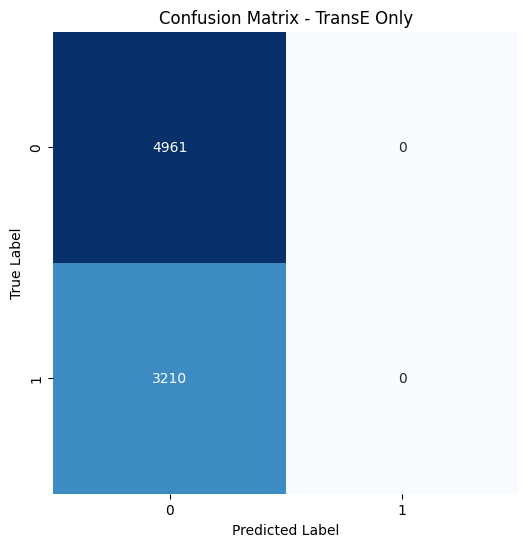

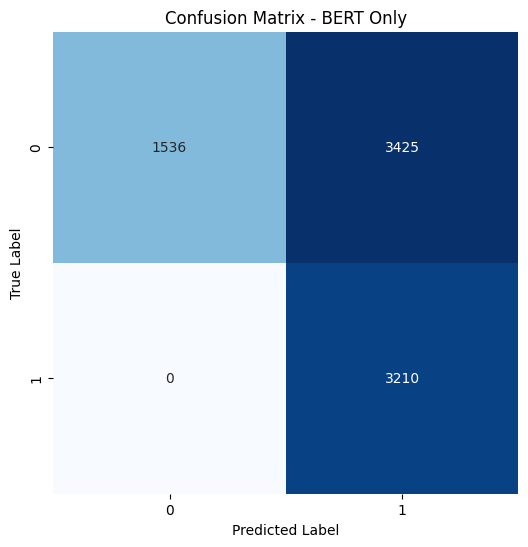

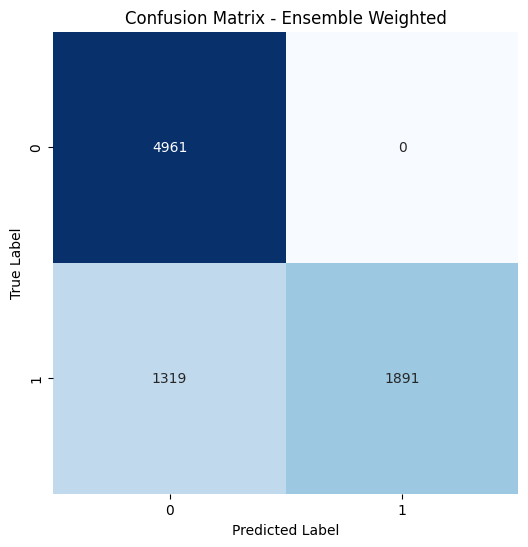

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels, model_name):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Evaluate TransE Only
def ensemble_predict(models, test_data_list):
    predictions = [torch.softmax(model(data), dim=1)[:, 1].detach().numpy() for model, data in zip(models, test_data_list)]
    avg_predictions = predictions[0]  # TransE only
    return (avg_predictions > 0.5).astype(int)

ensemble_preds = ensemble_predict(models, test_data_list)
plot_confusion_matrix(test_labels_tensor.numpy(), ensemble_preds, "TransE Only")

# Evaluate BERT Only
def ensemble_predict(models, test_data_list):
    predictions = [torch.softmax(model(data), dim=1)[:, 1].detach().numpy() for model, data in zip(models, test_data_list)]
    avg_predictions = predictions[1]  # BERT only
    return (avg_predictions > 0.5).astype(int)

ensemble_preds = ensemble_predict(models, test_data_list)
plot_confusion_matrix(test_labels_tensor.numpy(), ensemble_preds, "BERT Only")

# Evaluate Ensemble (Weighted)
def ensemble_predict(models, test_data_list):
    predictions = [torch.softmax(model(data), dim=1)[:, 1].detach().numpy() for model, data in zip(models, test_data_list)]
    avg_predictions = 0.58 * predictions[0] + 0.42 * predictions[1]  # Weighted average
    return (avg_predictions > 0.5).astype(int)

ensemble_preds = ensemble_predict(models, test_data_list)
plot_confusion_matrix(test_labels_tensor.numpy(), ensemble_preds, "Ensemble Weighted")


TransE model predicts all 1s. While BERT predicts two classes, the majority of the predictions are 1. After ensebmling, the model starts to predict bith classes with the majority being in class 1  as expected from the unbalanced distribution. This behavior could be further tuned with an ensembling weight. The FP and FN areas being lower than the TP and TN areas indicates a robust model.